## `Exercises`
Do your work for this exercise in a file named explore.

1) `Spam Data`

Load the spam data set.

Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

Is there any overlap in the bigrams for the spam data and the ham data?

Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

2) Explore the blog articles using the techniques discussed in the exploration lesson.

3) Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [1]:
import re
import unicodedata
import pandas as pd
import nltk
from wordcloud import WordCloud

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()


,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [3]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [4]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")


,n,percent
ham,4825,0.865937
spam,747,0.134063


In [5]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()


call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [6]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [7]:
word_counts.sort_values(by='all', ascending=False).head(10)


,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [8]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])


,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


1) `Spam Data`

`Load the spam data set.`

`Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?`

`Is there any overlap in the bigrams for the spam data and the ham data?`

`Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.`

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

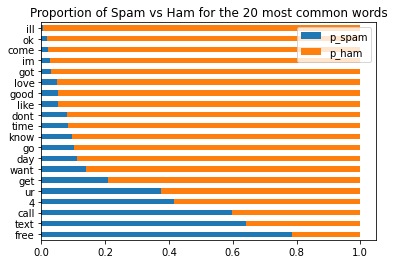

In [10]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')


In [11]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))


,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


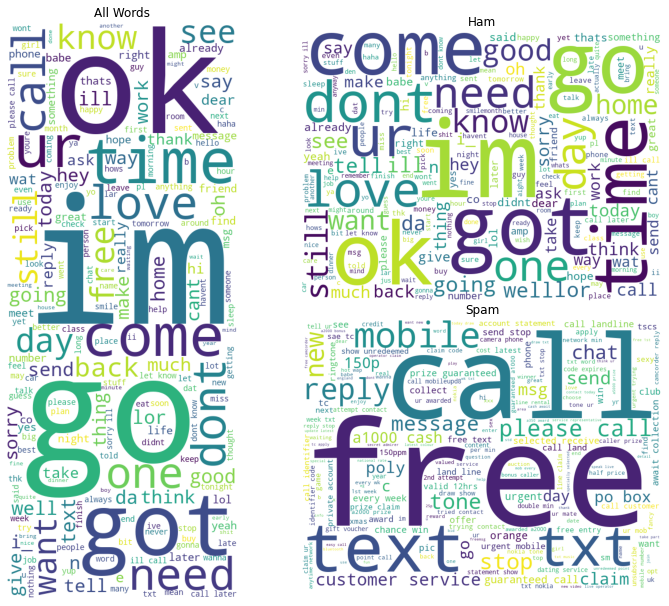

In [12]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')



In [13]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head(20)


(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(ok, lor)          22
(pls, send)        22
(im, gonna)        20
(good, night)      19
(happy, new)       19
(wat, time)        18
(last, night)      18
(hi, hi)           18
(great, day)       17
(dont, want)       15
(want, go)         15
dtype: int64

In [14]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))
top_20_spam_bigrams.head(20)

(please, call)          44
(customer, service)     27
(po, box)               24
(a1000, cash)           23
(guaranteed, call)      23
(prize, guaranteed)     22
(send, stop)            19
(selected, receive)     19
(await, collection)     19
(every, week)           19
(chance, win)           19
(urgent, mobile)        18
(land, line)            18
(valid, 12hrs)          17
(claim, call)           17
(sae, tc)               16
(account, statement)    16
(call, 08000930705)     16
(prize, claim)          16
(ur, mob)               15
dtype: int64

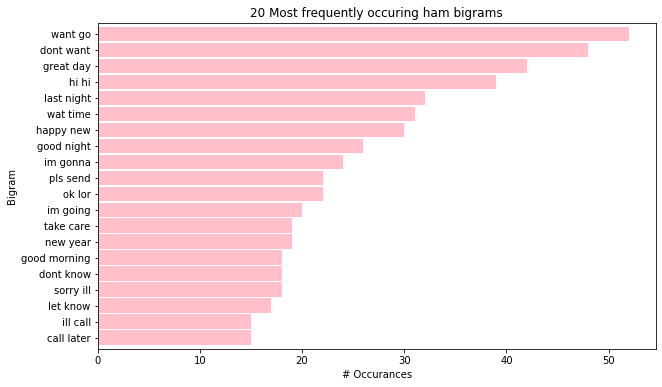

In [15]:
top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


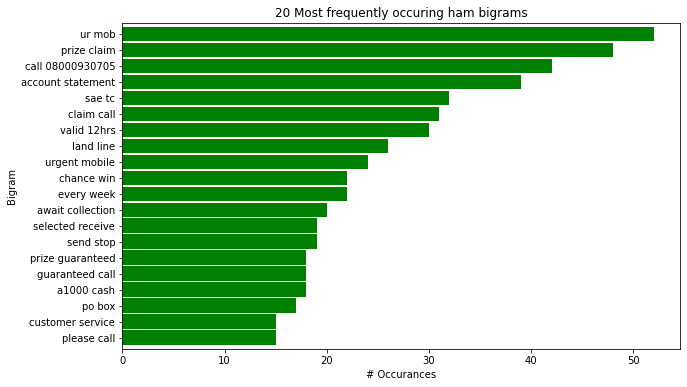

In [16]:
top_20_ham_bigrams.sort_values().plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


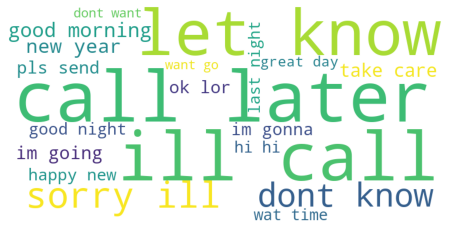

In [17]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


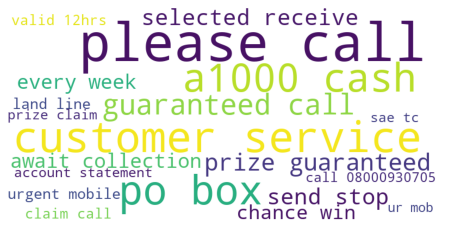

In [18]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

2) `Explore the blog articles using the techniques discussed in the exploration lesson.`


In [19]:
# bringing in data from acquire.py file
import acquire
df = acquire.blog_articles()

/Users/albertcontreras/codeup-data-science/natural-language-processing-exercises/acquire.py:35: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 35 of the file /Users/albertcontreras/codeup-data-science/natural-language-processing-exercises/acquire.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(url_response.text)


In [20]:
#bring in prep data
import prepare

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albertcontreras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/albertcontreras/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
codeup_df = acquire.blog_articles()

In [22]:
# renaming column name
codeup_df.rename(columns={'content':'original'}, inplace=True)

In [23]:
df = prepare.prep_article_data(codeup_df,'original', extra_words=['ha'],exclude_words=['no'])
df

,title,original,clean,stemmed,lemmatized
0,What Jobs Can You Get After a Coding Bootcamp?...,Have you been considering a career in Cloud Ad...,considering career cloud administration no ide...,consid career cloud administr no idea job titl...,considering career cloud administration no ide...
1,What Jobs Can You Get After a Coding Bootcamp?...,If you are interested in embarking on a career...,interested embarking career tech youre probabl...,interest embark career tech your probabl wonde...,interested embarking career tech youre probabl...
2,Is Our Cloud Administration Program Right for ...,Changing careers can be scary. The first thing...,changing careers scary first thing may asking ...,chang career scari first thing may ask begin l...,changing career scary first thing may asking b...
3,5 Reasons To Attend Our New Cloud Administrati...,Come Work In The Cloud\nWhen your Monday rolls...,come work cloud monday rolls around start get ...,come work cloud monday roll around start get s...,come work cloud monday roll around start get s...
4,Codeup TV Commercial,Codeup has officially made its TV debut! Our c...,codeup officially made tv debut community stud...,codeup offici made tv debut commun student sta...,codeup officially made tv debut community stud...
5,What Jobs Can You Get After a Coding Bootcamp?...,Have you been considering a career in Cloud Ad...,considering career cloud administration no ide...,consid career cloud administr no idea job titl...,considering career cloud administration no ide...
6,What Jobs Can You Get After a Coding Bootcamp?...,If you are interested in embarking on a career...,interested embarking career tech youre probabl...,interest embark career tech your probabl wonde...,interested embarking career tech youre probabl...
7,In-Person Workshop: Learn to Code – JavaScript...,Join us for our live in-person JavaScript cras...,join us live inperson javascript crash course ...,join us live inperson javascript crash cours d...,join u live inperson javascript crash course d...
8,In-Person Workshop: Learn to Code – Python on ...,"According to LinkedIn, the “#1 Most Promising ...",according linkedin 1 promising job data scienc...,accord linkedin 1 promis job data scienc one m...,according linkedin 1 promising job data scienc...
9,Free JavaScript Workshop at Codeup Dallas on 6/28,Event Info: \nLocation – Codeup Dallas\nTime –...,event info location codeup dallas time 6 pm co...,event info locat codeup dalla time 6 pm come l...,event info location codeup dallas time 6 pm co...


In [24]:
df['words'] = df.original.apply(clean)

In [25]:
all_words = ' '.join(df.words.apply(' '.join))
# Most common 15 words
pd.Series(all_words.split()).value_counts().head(15)

cloud             165
program            72
data               62
career             61
codeup             55
salary             46
administration     41
new                37
science            32
like               31
get                30
job                30
also               28
company            27
entrylevel         26
dtype: int64

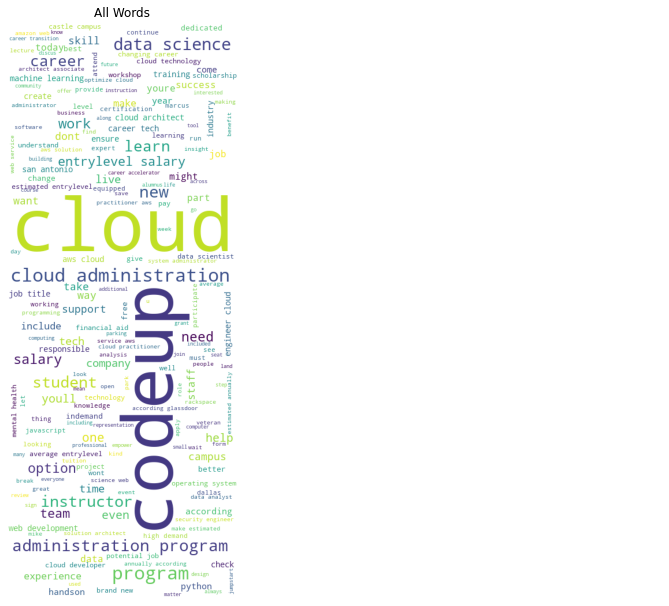

In [26]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate((all_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)


axs[0].set_title('All Words')


for ax in axs: ax.axis('off')


<AxesSubplot:>

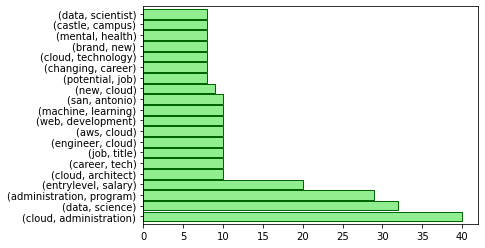

In [35]:
(
    df.words.apply(nltk.bigrams)
    .apply(pd.Series)
    .stack()
    .reset_index(drop=True)
    .value_counts()
    .head(20)
    .plot.barh(width=.9, ec='darkgreen', color='lightgreen')
)

3) `Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.`

In [36]:
#categories chosen
categories = ['world', 'science', 'technology', 'entertainment']
# naming data from acquired folder
news_df = acquire.get_shorts_articles(categories, refresh = False)
# renaming column name

In [38]:
# renaming column name
news_df.rename(columns={'contents':'original'},inplace=True)

In [39]:
df = prepare.prep_article_data(news_df,'original', extra_words=['ha'],exclude_words=['no'])
df

,title,original,clean,stemmed,lemmatized
0,Ranil Wickremesinghe elected as new President ...,"Amid the economic crisis in Sri Lanka, Ranil W...",amid economic crisis sri lanka ranil wickremes...,amid econom crisi sri lanka ranil wickremesing...,amid economic crisis sri lanka ranil wickremes...
1,Rishi Sunak among final 2 contenders for UK PM...,Former British Finance Minister Rishi Sunak an...,former british finance minister rishi sunak fo...,former british financ minist rishi sunak forei...,former british finance minister rishi sunak fo...
2,Reports claim India influenced Sri Lanka Presi...,The High Commission of India in Colombo on Wed...,high commission india colombo wednesday tweete...,high commiss india colombo wednesday tweet see...,high commission india colombo wednesday tweete...
3,Earth is basically empty of humans: Elon Musk ...,While commenting on a Twitter thread explainin...,commenting twitter thread explaining populatio...,comment twitter thread explain popul densiti a...,commenting twitter thread explaining populatio...
4,Indian embassy in SL shares pic of injured off...,The High Commission of India in Colombo has sh...,high commission india colombo shared picture o...,high commiss india colombo share pictur offici...,high commission india colombo shared picture o...
...,...,...,...,...,...
20,My producers tell me 'You double our money in ...,Following the success of his film 'Bhool Bhula...,following success film ' bhool bhulaiyaa 2 ' a...,follow success film ' bhool bhulaiyaa 2 ' acto...,following success film ' bhool bhulaiyaa 2 ' a...
21,I am done being the 'Harry Potter' of Bollywoo...,Actor Ranbir Kapoor said he is done being the ...,actor ranbir kapoor said done harry potter bol...,actor ranbir kapoor said done harri potter bol...,actor ranbir kapoor said done harry potter bol...
22,Director Sukumar said we have scope for 'Pushp...,Actor Fahadh Faasil has said there was no part...,actor fahadh faasil said no part one part two ...,actor fahadh faasil said no part one part two ...,actor fahadh faasil said no part one part two ...
23,I salute Sushmita Sen for living life on her o...,Filmmaker Mahesh Bhatt defended Sushmita Sen a...,filmmaker mahesh bhatt defended sushmita sen t...,filmmak mahesh bhatt defend sushmita sen troll...,filmmaker mahesh bhatt defended sushmita sen t...


In [40]:
df['words'] = df.original.apply(clean)

In [41]:
all_words = ' '.join(df.words.apply(' '.join))
# Most common 15 words
pd.Series(all_words.split()).value_counts().head(15)

said         62
added        22
twitter      22
film         22
musk         22
telescope    21
world        21
image        17
also         16
report       15
new          14
actor        14
u            14
space        13
billion      12
dtype: int64

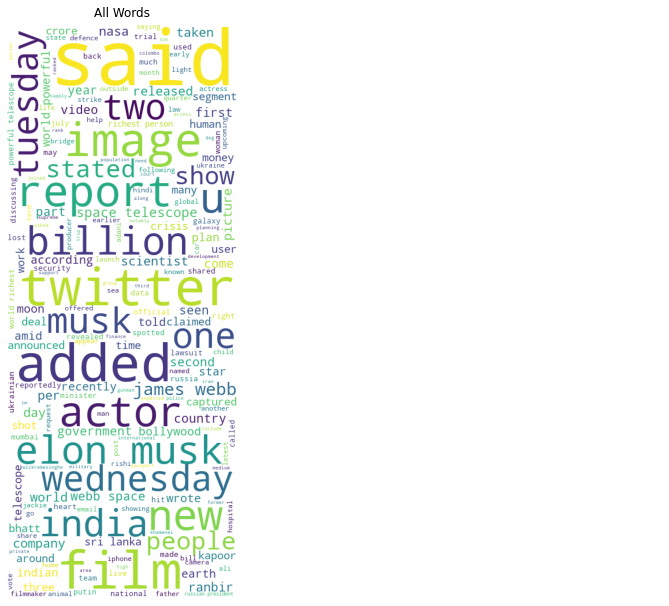

In [42]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate((all_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)


axs[0].set_title('All Words')


for ax in axs: ax.axis('off')


<AxesSubplot:>

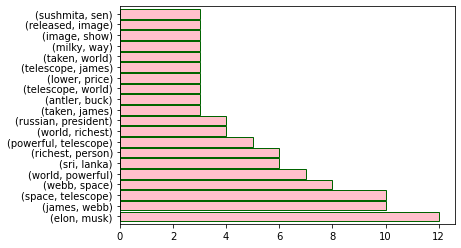

In [46]:
(
    df.words.apply(nltk.bigrams)
    .apply(pd.Series)
    .stack()
    .reset_index(drop=True)
    .value_counts()
    .head(20)
    .plot.barh(width=.9, ec='darkgreen', color='pink')
)